[[10]
 [10]
 [10]
 ..., 
 [ 9]
 [ 9]
 [ 9]]


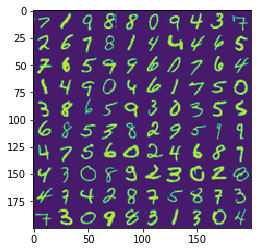

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import fmin_tnc
import random
import math

data = scipy.io.loadmat('ex4data1.mat')
Y_data = data["y"]

print(Y_data)

X = random.sample(list(data['X']),100)


def visualizeDigits(X):
    bigImg = np.zeros((200,200))
    
    xIndex = 0
    yIndex = 0
    
    for x in X:
        if xIndex == 200:
            yIndex += 20
            xIndex = 0
        img = np.reshape(x, (20,20)).T
        bigImg[xIndex:xIndex+20,yIndex:yIndex+20] = img
        xIndex += 20
    plt.imshow(bigImg)
    plt.show()
    return

visualizeDigits(X)

In [55]:
# transpose y so that it is a single row vector
# so it is better for "eye" matrix indexing
# also need to subtract one from every element in y

y_sub1 = np.vectorize(lambda x: x-1)(Y_data)
y_flip = y_sub1.T[0]

yMatrix = np.eye(10)[y_flip]
print(yMatrix)

[[ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]


In [76]:
# add bias column to X
X_data = np.insert(data["X"], 0, 1, axis=1)
print("X:\n", X_data, "\nShape: ", X_data.shape, "\n")

thetas = scipy.io.loadmat("ex4weights.mat")
theta1 = thetas["Theta1"]
theta2 = thetas["Theta2"]
print("theta1 shape: ", theta1.shape)
print("theta2 shape: ", theta2.shape)

def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def feedForward(theta1, theta2, X):
    theta1 = np.matrix(theta1)
    theta2 = np.matrix(theta2)
    
    a1 = X
    
    z1 = a1 * theta1.T
    a2 = np.insert(sigmoid(z1), 0, 1, axis=1) # sigmoid and add bias column
    
    print(a1, a1.shape)
    
    z2 = a2 * theta2.T # 5000x10 matrix
    a3 = sigmoid(z2)
    
    return a3

print(feedForward(theta1,theta2,X_data))


X:
 [[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]] 
Shape:  (5000, 401) 

theta1 shape:  (25, 401)
theta2 shape:  (10, 26)
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]] (5000, 401)
[[  1.12661530e-04   1.74127856e-03   2.52696959e-03 ...,   4.01468105e-04
    6.48072305e-03   9.95734012e-01]
 [  4.79026796e-04   2.41495958e-03   3.44755685e-03 ...,   2.39107046e-03
    1.97025086e-03   9.95696931e-01]
 [  8.85702310e-05   3.24266731e-03   2.55419797e-02 ...,   6.22892325e-02
    5.49803551e-03   9.28008397e-01]
 ..., 
 [  5.17641791e-02   3.81715020e-03   2.96297510e-02 ...,   2.15667361e-03
    6.49826950e-01   2.42384687e-05]
 [  8.30631310e-04   6.22003774e-04   3.14518512e-04 ...,

# there is a proof that for any matrix X,Y of size m by n,
# sum of entry-wide products is equal to tr(X.T * Y)

